Ce notebook décrit de manière concise la méthode utilisée pour calculer une distance (la hauteur d'un joueur, la largeur de la table etc) à partir deux images prises par deux caméras différentes.


In [1]:
import matplotlib.pyplot as plt
from math import *
import numpy as np
import cv2
from PIL import Image,ImageDraw
from google.colab import files


In [2]:
# on commence par importer les images sur lesquelles on va baser notre méthode
# on choisit 6 points sur les images dont on connaît avec précision leurs coordonnées dans l'espace 3D ( ci-dessous)
n=6
point1real=(0,-75.5,0)
X1,Y1,Z1=point1real
point2real=(0,75.5,0)
X2,Y2,Z2=point2real
point3real=(-93,75.5,0)
X3,Y3,Z3=point3real
point4real=(-67,-75.5,0)
X4,Y4,Z4=point4real
point5real=(-24,56,-76)
X5,Y5,Z5=point5real
point6real=(-24,-56,-76)
X6,Y6,Z6=point6real

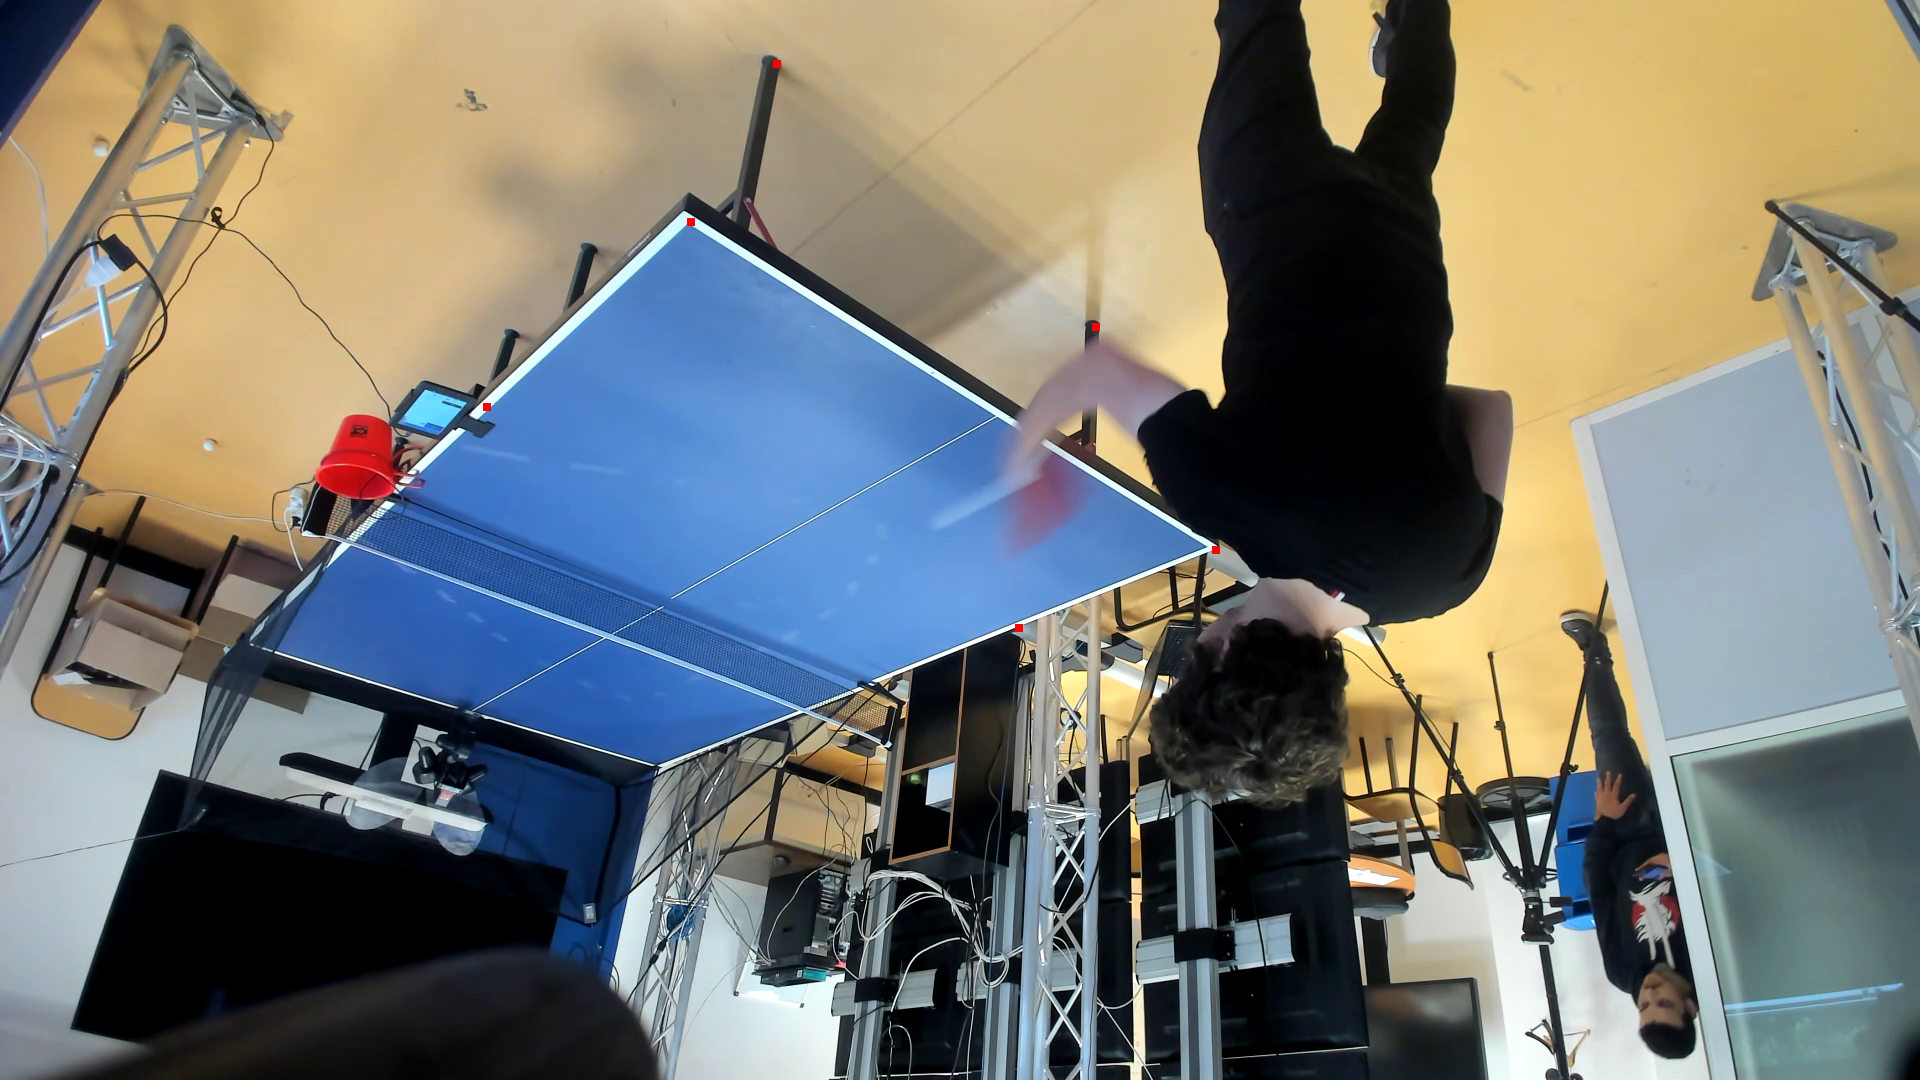

In [4]:
# premier frame pris par la caméra 1
n=6
image = Image.open("frame1.png")
w1,h1=image.size
# on définit les pixels qui correpondent à nos points de référence
color = (255, 0, 0)  # Rouge
u11,v11=(1212,546)
u21,v21=(687,218)
u31,v31=(483,403)
u41,v41=(1015,624)
u51,v51=(773,60)
u61,v61=(1092,323)
draw = ImageDraw.Draw(image)
# on visualise ces points sur notre image et on l'affiche
for i in range(n):
   x,y=eval('u'+str(10*(i+1)+1)),eval('v'+str(10*(i+1)+1))
   draw.rectangle((x, y, x+7, y+7), fill=color)
image.show()

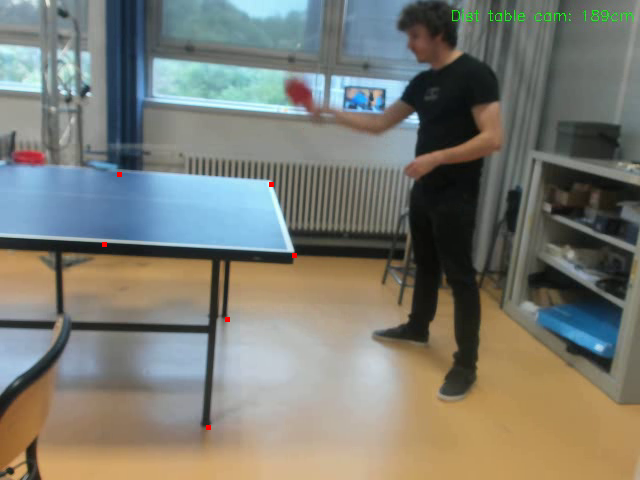

In [5]:
# premier frame pris par la caméra 3
n=6
image = Image.open("frame3.png")
w2,h2=image.size
# on définit les pixels qui correpondent à nos points de référence
u13,v13=(292,253)
u23,v23=(269,182)
u33,v33=(117,172)
u43,v43=(102,242)
u53,v53=(225,317)
u63,v63=(206,425)
# on visualise ces points sur notre image et on l'affiche
draw = ImageDraw.Draw(image)
# on visualise ces points sur notre image et on l'affiche
for i in range(n):
   x,y=eval('u'+str(10*(i+1)+3)),eval('v'+str(10*(i+1)+3))
   draw.rectangle((x, y, x+4, y+4), fill=color)
image.show()

Maintenant, on peut calculer la matrice de projection pour les deux images en résolvant un système matriciel et on peut remonter à toutes les grandeurs qui nous intéressent : position et orientation de la caméra, position du point principal, distance focale.
#Sytème à résoudre 

![Alt text](/content/systeme.png)

#Caméra 1



In [6]:
A=[]
for i in range(6):
  A.append([eval('X'+str(i+1)),eval('Y'+str(i+1)),eval('Z'+str(i+1)),1,0,0,0,0,eval('-'+'u'+str(10*(i+1)+1)+'*'+'X'+str(i+1)),eval('-'+'u'+str(10*(i+1)+1)+'*'+'Y'+str(i+1)),eval('-'+'u'+str(10*(i+1)+1)+'*'+'Z'+str(i+1)),eval('-u'+str(10*(i+1)+1))])
  A.append([0,0,0,0,eval('X'+str(i+1)),eval('Y'+str(i+1)),eval('Z'+str(i+1)),1,eval('-'+'v'+str(10*(i+1)+1)+'*'+'X'+str(i+1)),eval('-'+'v'+str(10*(i+1)+1)+'*'+'Y'+str(i+1)),eval('-'+'v'+str(10*(i+1)+1)+'*'+'Z'+str(i+1)),eval('-v'+str(10*(i+1)+1))])
# convert A to matrix
A=np.array(A)
# compute At x A
A_ = np.matmul(A.T, A)
# compute its eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(A_)
# find the eigenvector with the minimum eigenvalue
# (numpy already returns sorted eigenvectors wrt their eigenvalues)
m = eigenvectors[:,11]
# reshape m back to a matrix
M1 = m.reshape(3,4)
P=M1[:,:3]
p1=M1[:,0]
p2=M1[:,1]
p3=M1[:,2]
p4=M1[:,3]
m3=M1[2,:]
X =  np.linalg.det(np.column_stack((p2 ,p3 ,p4)))
Y = -np.linalg.det(np.column_stack((p1 ,p3 ,p4)))
Z =  np.linalg.det(np.column_stack((p1 ,p2 ,p4)))
T = - np.linalg.det(np.column_stack((p1 ,p2 ,p3)))
Pc = np.array([X,Y,Z,T])  
Pc = Pc/Pc[-1] 
Pc = Pc[:3]
pp = np.dot(M1,m3);
pp = pp/pp[2]; 
pp = pp[:2];
cx1,cy1=pp
Q,R=np.linalg.qr(M1[:3,:3])
for n in range(0,3):
      if R[n,n] < 0:
          R[:,n] = -R[:,n];
          Q[n,:] = -Q[n,:];
# calculer la distance de la caméra à l'origine du repère 3D
print('Distance prédite caméra 1 /origine en mètres :',"{:.2f}".format((sqrt(Pc[0]**2+Pc[1]**2+Pc[2]**2))*0.01)) # conversion en mètres
# comparer cette distance avec sa valeur réelle mesurée avec un laser
print('Distance réelle caméra 1 /origine en mètres :',2.402)
# afficher l'erreur
print('erreur de prédicition en m  : ',"{:.2f}".format((sqrt(Pc[0]**2+Pc[1]**2+Pc[2]**2)*0.01-2.402)))
# afficher l'erreur
print('erreur de prédicition en mètres  : ',"{:.2f}".format(abs((sqrt(Pc[0]**2+Pc[1]**2+Pc[2]**2)*0.01-2.857))),'\n')
print('matrice des caractéristiques intrinsèques de la caméra\n',R,'\n')
print('matrice de rotation  de la caméra\n',Q,'\n')
print("Position de la caméra dans l'espace 3D (","{:.2f}".format(Pc[0]),"{:.2f}".format(Pc[1]),"{:.2f}".format(Pc[2]),')')

Distance prédite caméra 1 /origine en mètres : 2.69
Distance réelle caméra 1 /origine en mètres : 2.402
erreur de prédicition en m  :  0.29
erreur de prédicition en mètres  :  0.17 

matrice des caractéristiques intrinsèques de la caméra
 [[ 2.71308610e-03 -1.78563037e-03 -3.18593030e-03]
 [-0.00000000e+00  5.59088970e-03 -1.15780930e-03]
 [-0.00000000e+00  0.00000000e+00  4.33180963e-06]] 

matrice de rotation  de la caméra
 [[ 2.04439209e-01  9.78879255e-01 -1.21986835e-04]
 [ 9.78878826e-01 -2.04439234e-01 -9.17970792e-04]
 [-9.23521460e-04  6.82588926e-05 -9.99999571e-01]] 

Position de la caméra dans l'espace 3D ( 162.20 142.62 160.17 )


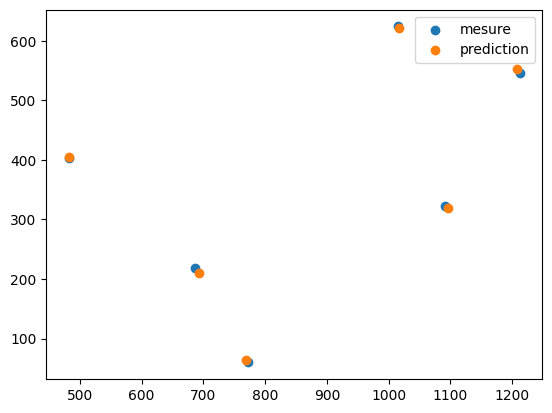

In [7]:
n=6
u_mesurees=[u11,u21,u31,u41,u51,u61]
u_predites=[]
v_mesurees=[v11,v21,v31,v41,v51,v61]
v_predites=[]
for i in range(n):
  x=np.dot(M1,np.array([eval('X'+str(i+1)),eval('Y'+str(i+1)),eval('Z'+str(i+1)),1]).T)
  x=x/x[-1]
  u_predites.append(x[0])
  v_predites.append(x[1])
# afficher les pixels mesurés et les prédictions sur un même graphe
plt.scatter(u_mesurees,v_mesurees,label='mesure')
plt.scatter(u_predites,v_predites,label='prediction')
plt.legend()
plt.show()


# Quantifier l'erreur de mesure
Nous représentons la projection des points 3D connus dans le repère des images via la matrice de calibration M1 et comparer les positions prédites avec les coordonnées en pixels ci-dessus.

# Caméra 2

In [8]:
A=[]
for i in range(6):
  A.append([eval('X'+str(i+1)),eval('Y'+str(i+1)),eval('Z'+str(i+1)),1,0,0,0,0,eval('-'+'u'+str(10*(i+1)+3)+'*'+'X'+str(i+1)),eval('-'+'u'+str(10*(i+1)+3)+'*'+'Y'+str(i+1)),eval('-'+'u'+str(10*(i+1)+3)+'*'+'Z'+str(i+1)),eval('-u'+str(10*(i+1)+3))])
  A.append([0,0,0,0,eval('X'+str(i+1)),eval('Y'+str(i+1)),eval('Z'+str(i+1)),1,eval('-'+'v'+str(10*(i+1)+3)+'*'+'X'+str(i+1)),eval('-'+'v'+str(10*(i+1)+3)+'*'+'Y'+str(i+1)),eval('-'+'v'+str(10*(i+1)+3)+'*'+'Z'+str(i+1)),eval('-v'+str(10*(i+1)+3))])
# convert A to matrix
A=np.array(A)
# compute At x A
A_ = np.matmul(A.T, A)
# compute its eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(A_)
# find the eigenvector with the minimum eigenvalue
# (numpy already returns sorted eigenvectors wrt their eigenvalues)
m = eigenvectors[:,11]
# reshape m back to a matrix
M2 = m.reshape(3,4)
P=M2[:,:3]
p1=M2[:,0]
p2=M2[:,1]
p3=M2[:,2]
p4=M2[:,3]
m3=M2[2,:]
X =  np.linalg.det(np.column_stack((p2 ,p3 ,p4)))
Y = -np.linalg.det(np.column_stack((p1 ,p3 ,p4)))
Z =  np.linalg.det(np.column_stack((p1 ,p2 ,p4)))
T = - np.linalg.det(np.column_stack((p1 ,p2 ,p3)))
Pc = np.array([X,Y,Z,T])  
Pc = Pc/Pc[-1] 
Pc = Pc[:3]
print(sqrt(Pc[0]**2+Pc[1]**2+Pc[2]**2))
pp = np.dot(M2,m3);
pp = pp/pp[2]; 
pp = pp[:2];  
cx2,cy2=pp
Q,R=np.linalg.qr(M2[:3,:3])
for n in range(0,3):
      if R[n,n] < 0:
          R[:,n] = -R[:,n];
          Q[n,:] = -Q[n,:];
# calculer la distance de la caméra à l'origine du repère 3D
print('Distance prédite caméra 2 /origine en mètres :',"{:.2f}".format((sqrt(Pc[0]**2+Pc[1]**2+Pc[2]**2))*0.01),'\n') # conversion en mètres
# comparer cette distance avec sa valeur réelle mesurée avec un laser
print('Distance réelle caméra 2 /origine en mètres :',2.857,'\n')
# afficher l'erreur
print('erreur de prédicition en mètres  : ',"{:.2f}".format(abs((sqrt(Pc[0]**2+Pc[1]**2+Pc[2]**2)*0.01-2.857))),'\n')
print('matrice des caractéristiques intrinsèques de la caméra 2 \n',R,'\n')
print('matrice de rotation  de la caméra 2 \n',Q,'\n')
print("Position de la caméra dans l'espace 3D (","{:.2f}".format(Pc[0]),"{:.2f}".format(Pc[1]),"{:.2f}".format(Pc[2]),')')

292.6594276176123
Distance prédite caméra 2 /origine en mètres : 2.93 

Distance réelle caméra 2 /origine en mètres : 2.857 

erreur de prédicition en mètres  :  0.07 

matrice des caractéristiques intrinsèques de la caméra 2 
 [[ 6.10228385e-03  2.47531656e-03  2.88249467e-04]
 [-0.00000000e+00  5.87103006e-04  6.13351844e-03]
 [-0.00000000e+00 -0.00000000e+00  9.87760291e-05]] 

matrice de rotation  de la caméra 2 
 [[ 9.96090936e-01 -8.83241450e-02 -1.30116050e-03]
 [ 8.83336293e-02  9.95959662e-01  1.61716147e-02]
 [-1.32440667e-04 -1.62233350e-02  9.99868384e-01]] 

Position de la caméra dans l'espace 3D ( -20.46 -286.01 58.58 )


# Quantifier l'erreur de mesure

Nous représentons la projection des points 3D connus dans le repère des images via la matrice de calibration M2 et comparer les positions prédites avec les coordonnées en pixels ci-dessus.

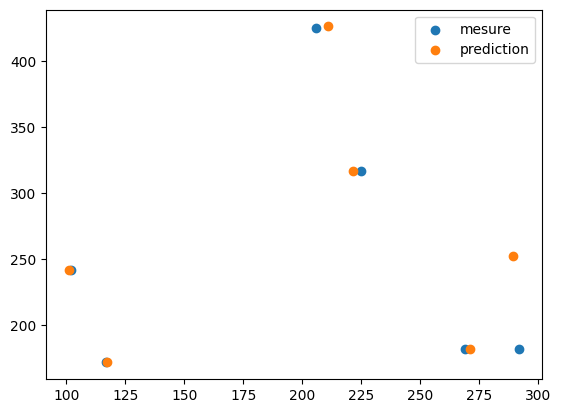

In [9]:
n=6
u_mesurees=[u13,u23,u33,u43,u53,u63]
u_predites=[]
v_mesurees=[v23,v23,v33,v43,v53,v63]
v_predites=[]
for i in range(n):
  x=np.dot(M2,np.array([eval('X'+str(i+1)),eval('Y'+str(i+1)),eval('Z'+str(i+1)),1]).T)
  x=x/x[-1]
  u_predites.append(x[0])
  v_predites.append(x[1])
# afficher les pixels mesurés et les prédictions sur un même graphe
plt.scatter(u_mesurees,v_mesurees,label='mesure')
plt.scatter(u_predites,v_predites,label='prediction')
plt.legend()
plt.show()


# Calcul d'une distance ou de la hauteur du joueur